Importando bibliotecas necessárias para o modelo de XGBoost Regressor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

Lendo arquivo .csv (upwork-jobs)

In [ ]:
df = pd.read_csv("upwork-jobs.csv")
df.head()

,title,link,description,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,We’re looking for a talented and hardworking a...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,Job Title: Full Stack DeveloperWe are seeking ...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,I need someone to redesign my bubble.io site t...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,Join Our Growing Team!We are an innovative com...,2024-02-17 09:08:08+00:00,NaN,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,We are looking for a resource who can work par...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India


Realizando limpeza de valores nulos

In [ ]:
df = df.dropna(subset=['title', 'description', 'is_hourly', 'budget'])
df = df[df['is_hourly'] == False]
df.shape

(21873, 9)

Criando coluna valor_justo

In [ ]:
def calcular_valor_justo_projeto(row):
    texto = row['title'] + " " + row['description']
    comprimento = len(texto.split())
    fator_complexidade = min(comprimento / 100, 1.0)  # até 100 palavras
    return row['budget'] * (0.5 + 0.5 * fator_complexidade)

df['valor_justo'] = df.apply(calcular_valor_justo_projeto, axis=1)
df.head()

,title,link,description,published_date,is_hourly,hourly_low,hourly_high,budget,country,valor_justo
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,We’re looking for a talented and hardworking a...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN,500.0
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,Job Title: Full Stack DeveloperWe are seeking ...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States,1100.0
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,We are looking for a resource who can work par...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India,650.0
6,Want to fix the WordPress Plugin,https://www.upwork.com/jobs/Want-fix-the-WordP...,I am currently facing some issues with a custo...,2024-02-17 09:07:27+00:00,False,NaN,NaN,5.0,India,4.0
9,PHP/HTML/CSS WordPress Developer Needed for We...,https://www.upwork.com/jobs/PHP-HTML-CSS-WordP...,**Description:**We are seeking an experienced ...,2024-02-17 09:06:21+00:00,False,NaN,NaN,500.0,Canada,500.0


Limpando outliers

In [ ]:
Q1 = df['valor_justo'].quantile(0.25)
Q3 = df['valor_justo'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
df = df[(df['valor_justo'] >= limite_inferior) & (df['valor_justo'] <= limite_superior)]

Juntando título e descrição

In [ ]:
df['texto'] = df['title'] + " " + df['description']

Divisão dos dados entre treinamento e teste

In [ ]:
X = df[['texto']]
y = df['valor_justo']
X_train, X_test, y_train, y_test = train_test_split(X['texto'], y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(15312,)

In [ ]:
X_test.shape

(3828,)

Vetorização TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Treinando o modelo XGBoost Regressor

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train_tfidf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Realizando previsões

In [ ]:
y_pred = xgb_model.predict(X_test_tfidf)

Avaliando desempenho do modelo

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 35.95
MAE: 11.03
R²: 0.9467


Visualização das previsões

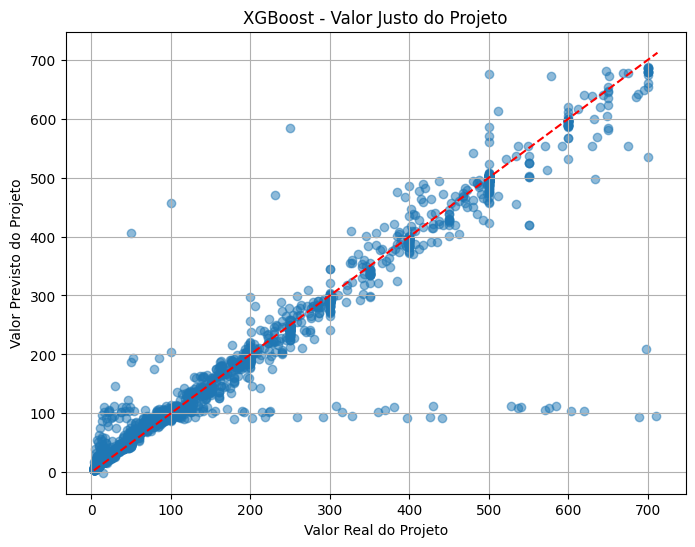

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor Real do Projeto")
plt.ylabel("Valor Previsto do Projeto")
plt.title("XGBoost - Valor Justo do Projeto")
plt.grid(True)
plt.show()

Salvando o modelo e vetorizador com Pickle

In [ ]:
with open('modelo_xgboost_valor_projeto.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

with open('tfidf_vectorizer_valor_projeto.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

print("Modelo XGBoost e vetorizador TF-IDF para preço justo salvos com sucesso!")


Modelo XGBoost e vetorizador TF-IDF para preço justo salvos com sucesso!
